In [1]:
import os

In [2]:
folder = 'Данные_Эксперимент_2'

## Загрузка данных

In [34]:
import json

# Входные данные
with open(os.path.join(folder, 'description_indexes.json'), 'r') as f:
    description_indexes = json.load(f)
    
# Словарь
with open(os.path.join(folder, 'dictionary.json'), 'r') as f:
    dictionary = json.load(f)

## Признаки
with open(os.path.join(folder, 'index_1_labels.json'), 'r') as f:
    index_1_labels = json.load(f)
    
with open(os.path.join(folder, 'index_2_labels.json'), 'r') as f:
    index_2_labels = json.load(f)
    
with open(os.path.join(folder, 'index_3_labels.json'), 'r') as f:
    index_3_labels = json.load(f)
    
with open(os.path.join(folder, 'index_4_labels.json'), 'r') as f:
    index_4_labels = json.load(f)
    
with open(os.path.join(folder, 'index_5_labels.json'), 'r') as f:
    index_5_labels = json.load(f)

In [35]:
NUM_INDEXES = len(dictionary)

NUM_1_CLASSES = len(set(index_1_labels))
NUM_2_CLASSES = len(set(index_2_labels))
NUM_3_CLASSES = len(set(index_3_labels))
NUM_4_CLASSES = len(set(index_4_labels))
NUM_5_CLASSES = len(set(index_5_labels))

In [36]:
NUM_INDEXES, NUM_1_CLASSES, NUM_2_CLASSES, NUM_3_CLASSES, NUM_4_CLASSES, NUM_5_CLASSES

(52304, 3, 3, 13, 24, 257)

В эксперименте 1 были следующие цифры  
(45219, 3, 3, 23, 54, 459)

## Датасет

In [37]:
import torch
from torch.utils.data import DataLoader, Dataset

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [39]:
class SentDataset(Dataset):

    def __init__(self, indexes, labels, max_len=None):
        self.indexes = indexes
        self.labels_1 = labels[0]
        self.labels_2 = labels[1]
        self.labels_3 = labels[2]
        self.labels_4 = labels[3]
        self.labels_5 = labels[4]
        if max_len:
            self.MAX_LEN = max_len
        else:
            self.MAX_LEN = len(max(indexes, key=len))
        self.NULL_INDEX = 0

    def __getitem__(self, i):
        
        row = self.indexes[i]
        label_1 = self.labels_1[i]
        label_2 = self.labels_2[i]
        label_3 = self.labels_3[i]
        label_4 = self.labels_4[i]
        label_5 = self.labels_5[i]
        
        if len(row) < self.MAX_LEN:
            padded_matrix = row + [self.NULL_INDEX] * (self.MAX_LEN - len(row))
        else:
            padded_matrix = row[:self.MAX_LEN]

        x = torch.tensor(padded_matrix, dtype=torch.long, device=device)
        y1 = torch.tensor(label_1, dtype=torch.long, device=device)
        y2 = torch.tensor(label_2, dtype=torch.long, device=device)
        y3 = torch.tensor(label_3, dtype=torch.long, device=device)
        y4 = torch.tensor(label_4, dtype=torch.long, device=device)
        y5 = torch.tensor(label_5, dtype=torch.long, device=device)
        
        return (x, (y1, y2, y3, y4, y5))

    def __len__(self):
        return len(self.indexes)

In [40]:
dataset = SentDataset(description_indexes, (index_1_labels, index_2_labels, index_3_labels, index_4_labels, index_5_labels))

In [41]:
X, y = dataset[10]
X, y

(tensor([208, 209, 210, 211,   2,   6, 182, 212, 213, 214, 215, 211, 216, 199,
         217, 218, 219,  18,  26, 220, 221, 222, 223,  15, 224,  35, 156,   2,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0]),
 (tensor(1), tensor(1), tensor(2), tensor(8), tensor(29)))

In [42]:
total_samples = len(dataset)
train_samples = int(0.7 * total_samples)
train_indices = list(range(train_samples))
test_indices = list(range(train_samples, total_samples))
train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

In [43]:
batch_size = 256

In [44]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

## Модель

In [45]:
import torch.nn as nn

In [46]:
class RNN(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers, bidirectional=True):
        super(RNN, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = True
        self.output_size_1 = output_size[0]
        self.output_size_2 = output_size[1]
        self.output_size_3 = output_size[2]
        self.output_size_4 = output_size[3]
        self.output_size_5 = output_size[4]

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        # в эксперименте 2 добавим слой dropout
        self.dropout = nn.Dropout(0.2)
        self.fc_1 = nn.Linear(2*hidden_size, output_size[0])
        self.fc_2 = nn.Linear(2*hidden_size, output_size[1])
        self.fc_3 = nn.Linear(2*hidden_size, output_size[2])
        self.fc_4 = nn.Linear(2*hidden_size, output_size[3])
        self.fc_5 = nn.Linear(2*hidden_size, output_size[4])

    def forward(self, input_):
        embedded = self.embedding(input_)
        output = embedded
        _, (hidden, s) = self.rnn(output)
        
        hidden_states_forward = hidden[-1]
        hidden_states_backward = hidden[0]
        hidden_states = torch.cat((hidden_states_forward, hidden_states_backward), dim=1)
        
        hidden_states = self.dropout(hidden_states)
        
        output_1 = self.fc_1(hidden_states)
        output_2 = self.fc_2(hidden_states)
        output_3 = self.fc_3(hidden_states)
        output_4 = self.fc_4(hidden_states)
        output_5 = self.fc_5(hidden_states)
        return (output_1, output_2, output_3, output_4, output_5, )

In [47]:
input_size = NUM_INDEXES
embedding_size = 64
hidden_size = 64
output_size = (NUM_1_CLASSES, NUM_2_CLASSES, NUM_3_CLASSES, NUM_4_CLASSES, NUM_5_CLASSES)
# В эксперименте 2 делаем LSTM ячейку однослойной, так как возможно мы в эксперименте 1 сделали модель более сложной
num_layers = 1

In [48]:
model = RNN(input_size, embedding_size, hidden_size, output_size, num_layers).to(device)

## Функции обучения

In [49]:
import torch.optim as optim

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

In [51]:
def train(model, iterator, criterion, optimizer, scheduler=None):
    model.train()
    sum_loss_1 = 0.0
    sum_loss_2 = 0.0
    sum_loss_3 = 0.0
    sum_loss_4 = 0.0
    sum_loss_5 = 0.0
    correct_1 = 0
    correct_2 = 0
    correct_3 = 0
    correct_4 = 0
    correct_5 = 0
    total = 0
    num_batch = 0
    for X, y in iterator:
        optimizer.zero_grad()
        text = X.to(device)
        labels = [label.to(device) for label in y]
        predictions = model(text)
        
        loss_1 = criterion(predictions[0], labels[0])
        loss_2 = criterion(predictions[1], labels[1])
        loss_3 = criterion(predictions[2], labels[2])
        loss_4 = criterion(predictions[3], labels[3])
        loss_5 = criterion(predictions[4], labels[4])     
        sum_loss_1 += loss_1.item()
        sum_loss_2 += loss_2.item()
        sum_loss_3 += loss_3.item()
        sum_loss_4 += loss_4.item()
        sum_loss_5 += loss_5.item()
        
        ((loss_1+loss_2+loss_3+loss_4+loss_5)/5).backward()
        
        optimizer.step()
        
        num_batch += 1
        predicted_classes_1 = torch.argmax(predictions[0], dim=1)
        predicted_classes_2 = torch.argmax(predictions[1], dim=1)
        predicted_classes_3 = torch.argmax(predictions[2], dim=1)
        predicted_classes_4 = torch.argmax(predictions[3], dim=1)
        predicted_classes_5 = torch.argmax(predictions[4], dim=1)
        correct_1 += (predicted_classes_1 == labels[0]).sum().item()
        correct_2 += (predicted_classes_2 == labels[1]).sum().item()
        correct_3 += (predicted_classes_3 == labels[2]).sum().item()
        correct_4 += (predicted_classes_4 == labels[3]).sum().item()
        correct_5 += (predicted_classes_5 == labels[4]).sum().item()
        total += labels[0].size(0)
        
    accuracy_1 = correct_1 / total
    accuracy_2 = correct_2 / total
    accuracy_3 = correct_3 / total
    accuracy_4 = correct_4 / total
    accuracy_5 = correct_5 / total
    sum_loss_1 /= len(iterator)
    sum_loss_2 /= len(iterator)
    sum_loss_3 /= len(iterator)
    sum_loss_4 /= len(iterator)
    sum_loss_5 /= len(iterator)
    
    if scheduler:
        scheduler.step()
            
    return (
        (round(sum_loss_1, 4), round(sum_loss_2, 4), round(sum_loss_3, 4), round(sum_loss_4, 4), round(sum_loss_5, 4)),
        (round(accuracy_1, 4), round(accuracy_2, 4), round(accuracy_3, 4), round(accuracy_4, 4), round(accuracy_5, 4), )
    )

In [52]:
# Процесс оценки
def evaluate(model, iterator, criterion):
    model.eval()
    sum_loss_1 = 0.0
    sum_loss_2 = 0.0
    sum_loss_3 = 0.0
    sum_loss_4 = 0.0
    sum_loss_5 = 0.0
    correct_1 = 0
    correct_2 = 0
    correct_3 = 0
    correct_4 = 0
    correct_5 = 0
    total = 0
    with torch.no_grad():
        for X, y in iterator:
            text = X.to(device)
            labels = [label.to(device) for label in y]
            predictions = model(text)
            
            sum_loss_1 += criterion(predictions[0], labels[0]).item()
            sum_loss_2 += criterion(predictions[1], labels[1]).item()
            sum_loss_3 += criterion(predictions[2], labels[2]).item()
            sum_loss_4 += criterion(predictions[3], labels[3]).item()
            sum_loss_5 += criterion(predictions[4], labels[4]).item()
            
            predicted_classes_1 = torch.argmax(predictions[0], dim=1)
            predicted_classes_2 = torch.argmax(predictions[1], dim=1)
            predicted_classes_3 = torch.argmax(predictions[2], dim=1)
            predicted_classes_4 = torch.argmax(predictions[3], dim=1)
            predicted_classes_5 = torch.argmax(predictions[4], dim=1)
            correct_1 += (predicted_classes_1 == labels[0]).sum().item()
            correct_2 += (predicted_classes_2 == labels[1]).sum().item()
            correct_3 += (predicted_classes_3 == labels[2]).sum().item()
            correct_4 += (predicted_classes_4 == labels[3]).sum().item()
            correct_5 += (predicted_classes_5 == labels[4]).sum().item()
            total += labels[0].size(0)
            
    accuracy_1 = correct_1 / total
    accuracy_2 = correct_2 / total
    accuracy_3 = correct_3 / total
    accuracy_4 = correct_4 / total
    accuracy_5 = correct_5 / total
    sum_loss_1 /= len(iterator)
    sum_loss_2 /= len(iterator)
    sum_loss_3 /= len(iterator)
    sum_loss_4 /= len(iterator)
    sum_loss_5 /= len(iterator)
    
    return  (
        (round(sum_loss_1, 4), round(sum_loss_2, 4), round(sum_loss_3, 4), round(sum_loss_4, 4), round(sum_loss_5, 4)),
        (round(accuracy_1, 4), round(accuracy_2, 4), round(accuracy_3, 4), round(accuracy_4, 4), round(accuracy_5, 4), )
    )

In [53]:
from IPython.display import clear_output

In [54]:
data = {
    'train_loss': [[], [], [], [], []],
    'train_accuracy': [[], [], [], [], []],
    'test_loss': [[], [], [], [], []],
    'test_accuracy': [[], [], [], [], []],
}

## Функции для визуализации

In [56]:
from matplotlib import pyplot as plt

In [57]:
def plot_learning_curves(data):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 20))

    plt.subplot(2,2,1)
    plt.title('Обучение. Лосс', fontsize=15)
    plt.plot(data['train_loss'][0], label='label 1')
    plt.plot(data['train_loss'][1], label='label 2')
    plt.plot(data['train_loss'][2], label='label 3')
    plt.plot(data['train_loss'][3], label='label 4')
    plt.plot(data['train_loss'][4], label='label 5')
    plt.ylabel('Лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(2,2,2)
    plt.title('Обучение. Точность', fontsize=15)
    plt.plot(data['train_accuracy'][0], label='label 1')
    plt.plot(data['train_accuracy'][1], label='label 2')
    plt.plot(data['train_accuracy'][2], label='label 3')
    plt.plot(data['train_accuracy'][3], label='label 4')
    plt.plot(data['train_accuracy'][4], label='label 5')
    plt.ylabel('Точность', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    
    plt.subplot(2,2,3)
    plt.title('Тест. Лосс', fontsize=15)
    plt.plot(data['test_loss'][0], label='label 1')
    plt.plot(data['test_loss'][1], label='label 2')
    plt.plot(data['test_loss'][2], label='label 3')
    plt.plot(data['test_loss'][3], label='label 4')
    plt.plot(data['test_loss'][4], label='label 5')
    plt.ylabel('Лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(2,2,4)
    plt.title('Тест. Точность', fontsize=15)
    plt.plot(data['test_accuracy'][0], label='label 1')
    plt.plot(data['test_accuracy'][1], label='label 2')
    plt.plot(data['test_accuracy'][2], label='label 3')
    plt.plot(data['test_accuracy'][3], label='label 4')
    plt.plot(data['test_accuracy'][4], label='label 5')
    plt.ylabel('Точность', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    
    plt.show()

In [58]:
def updata(data):
    for place, item in zip(data['train_loss'], train_loss):
        place.append(item)

    for place, item in zip(data['train_accuracy'], train_accuracy):
        place.append(item)

    for place, item in zip(data['test_loss'], test_loss):
        place.append(item)

    for place, item in zip(data['test_accuracy'], test_accuracy):
        place.append(item)
    
    return data

## Обучение

Epoch: 150
Train loss: (0.1865, 0.7724, 0.6673, 0.7072, 2.4553)
Train accuracy: (0.9383, 0.6495, 0.8053, 0.8045, 0.3845)
Test loss: (0.4029, 0.7905, 0.9467, 1.1584, 2.7836)
Test accuracy: (0.8879, 0.6424, 0.7397, 0.6954, 0.3325)


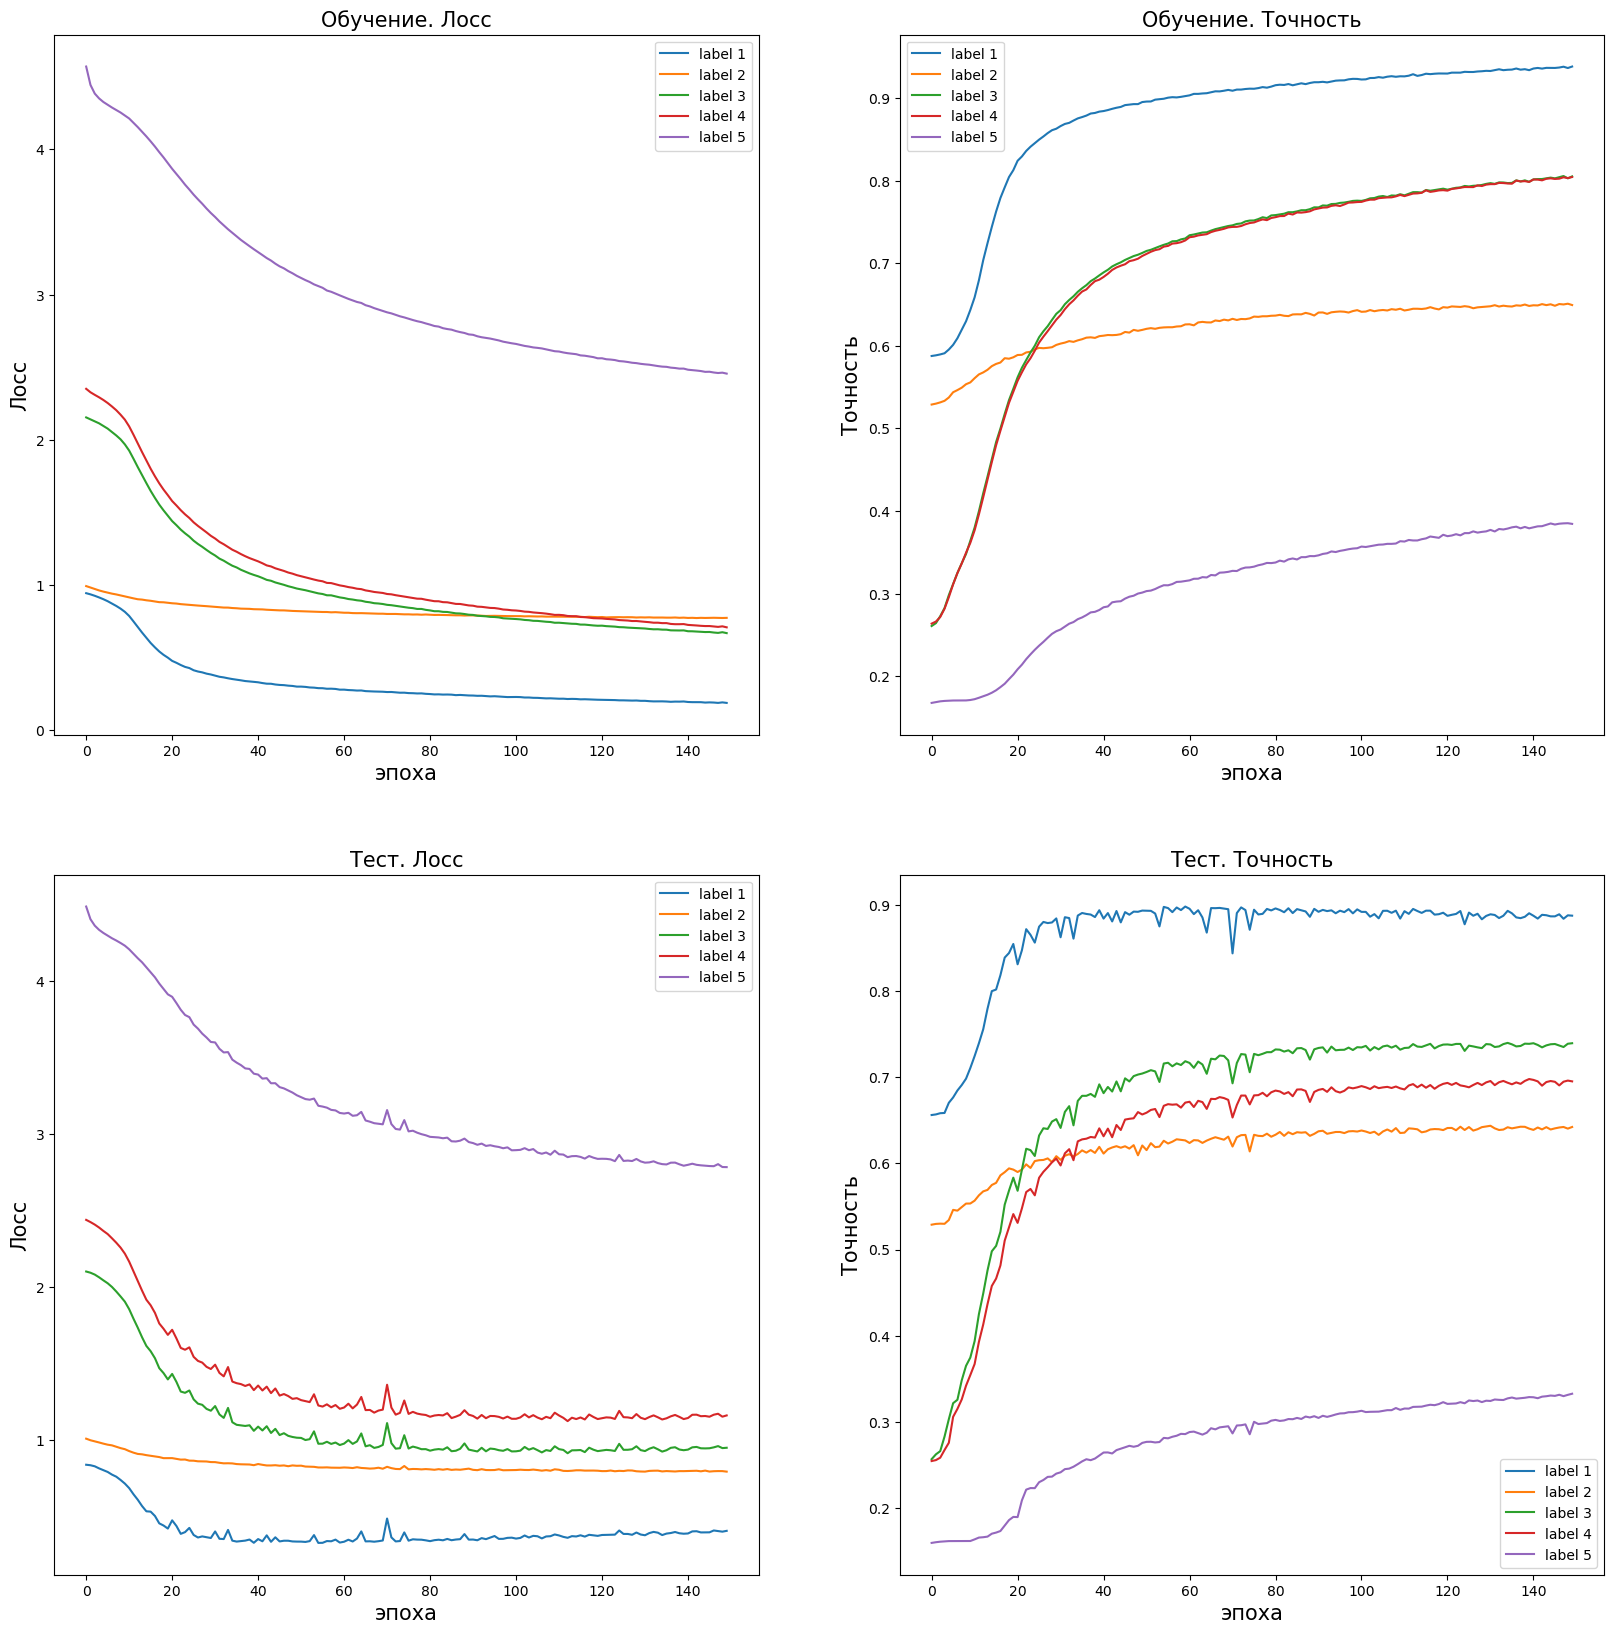

In [59]:
for epoch in range(150):
    train_loss, train_accuracy = train(model, train_dataloader, criterion, optimizer)
    test_loss, test_accuracy = evaluate(model, test_dataloader, criterion)
    data = updata(data)
    
    clear_output()
    
    print(f'Epoch: {epoch+1}')
    print(f'Train loss: {train_loss}')
    print(f'Train accuracy: {train_accuracy}')
    print(f'Test loss: {test_loss}')
    print(f'Test accuracy: {test_accuracy}')
    plot_learning_curves(data)

## Итоги
- В целом результаты остались на прежнем уровне

## Что еще можно было бы сделать
- Изменить гиперпараметры модели, а именно embedding_size и hidden_size
- Увеличим размер пакета batch_size
- Попробовать усложнить модель, сделать чытерехслойную LSTM